In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

from joblib import dump,load

plt.style.use('ggplot')
plt.rc(
    'figure',
    autolayout=True,
    figsize=(11,4)
)

plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=20,
    titlepad=10
)

In [16]:
dataframe = pd.read_csv('../data/msft_raw.csv',usecols=['DATE','OPCP','HPCP','LPCP','CPCP','ACPCP','VTCP', 'MPN5P'], index_col='DATE')

dataframe.index = pd.to_datetime(dataframe.index)
dataframe.head()

,OPCP,HPCP,LPCP,CPCP,ACPCP,VTCP,MPN5P
DATE,,,,,,,
2000-02-29,45.87500,45.875000,44.43750,44.68750,27.880445,58437400,46.765625
2000-03-01,44.81250,47.046875,44.46875,45.40625,28.328880,106889800,47.070312
2000-03-02,45.90625,47.687500,45.56250,46.68750,29.128248,106932600,47.656250
2000-03-03,47.37500,49.437500,46.93750,48.06250,29.986110,101435200,48.000000
2000-03-06,48.00000,48.687500,45.06250,45.31250,28.270390,93609400,48.750000


In [17]:
train_end = '2022-10-28'
train = dataframe.loc[:train_end,:]
test = dataframe.loc[train_end:,:].drop(train_end,axis=0)

In [18]:
train = train.reset_index()
train.head()

,DATE,OPCP,HPCP,LPCP,CPCP,ACPCP,VTCP,MPN5P
0,2000-02-29,45.87500,45.875000,44.43750,44.68750,27.880445,58437400,46.765625
1,2000-03-01,44.81250,47.046875,44.46875,45.40625,28.328880,106889800,47.070312
2,2000-03-02,45.90625,47.687500,45.56250,46.68750,29.128248,106932600,47.656250
3,2000-03-03,47.37500,49.437500,46.93750,48.06250,29.986110,101435200,48.000000
4,2000-03-06,48.00000,48.687500,45.06250,45.31250,28.270390,93609400,48.750000


Train shape: (955, 6) | Test Shape: (950, 6)
For fold 0 RMSE: 4.106301751278546


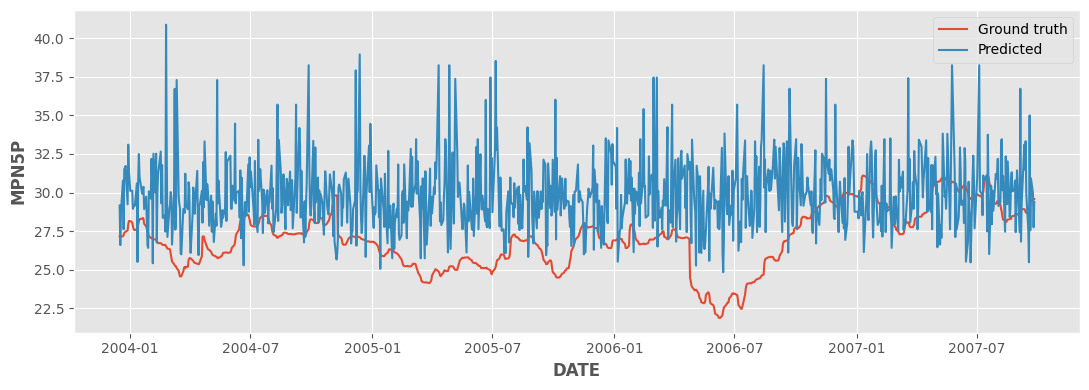

Train shape: (1032, 6) | Test Shape: (950, 6)
For fold 1 RMSE: 4.238743790602166


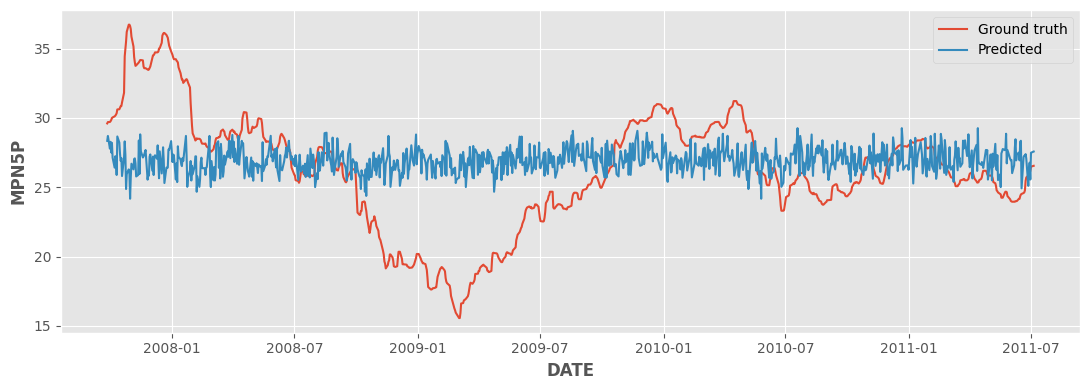

Train shape: (1032, 6) | Test Shape: (950, 6)
For fold 2 RMSE: 9.782292856442734


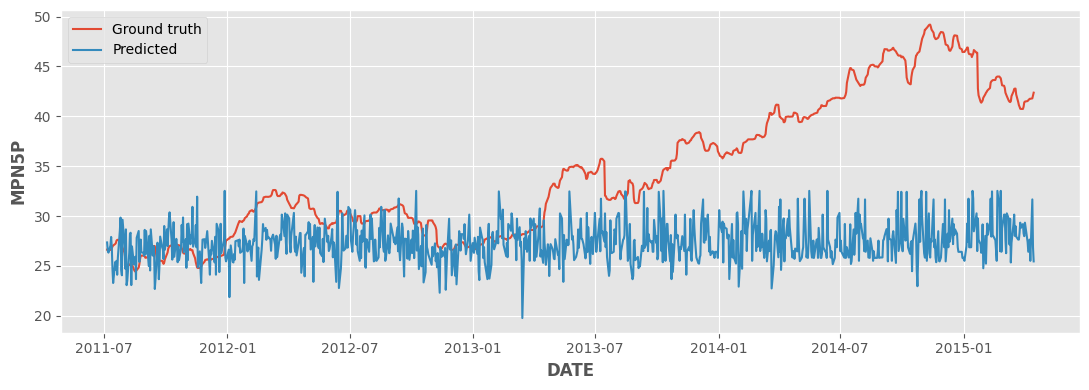

Train shape: (1032, 6) | Test Shape: (950, 6)
For fold 3 RMSE: 39.851201251111355


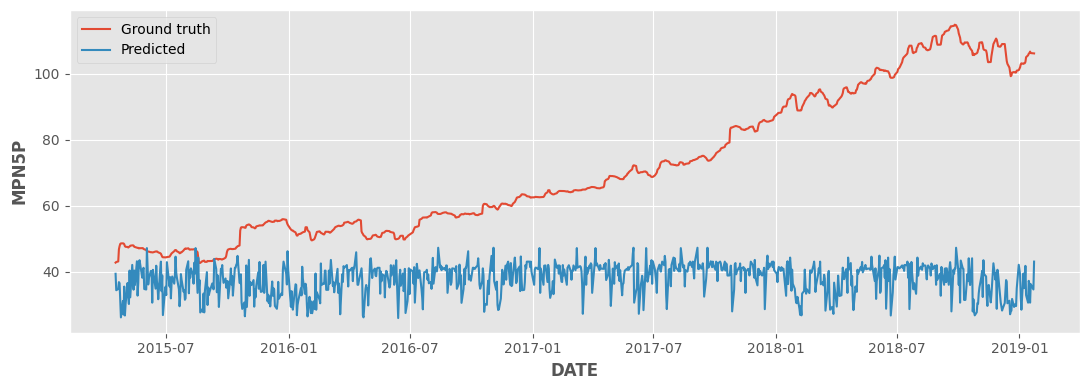

Train shape: (1032, 6) | Test Shape: (950, 6)
For fold 4 RMSE: 163.2779249433446


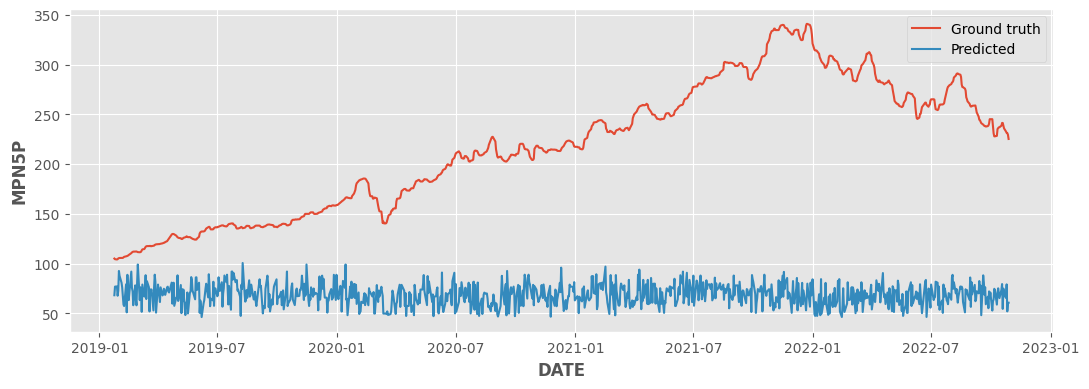

In [19]:
features = ['OPCP','HPCP','LPCP','CPCP','ACPCP','VTCP']
target = 'MPN5P'
plot = True
save_models = True

tss = TimeSeriesSplit(n_splits=5,max_train_size=test.shape[0] * 6)
rmse_scores = []
for fold, (train_idx,val_idx) in enumerate(tss.split(train)):
    train_dates, val_dates = train.loc[train_idx,'DATE'], train.loc[val_idx,'DATE']
    X_train, y_train = train.loc[train_idx, features], train.loc[train_idx, target]
    X_val, y_val = train.loc[val_idx, features], train.loc[val_idx,target]

    print("Train shape:", X_train.shape, "|", "Test Shape:", X_val.shape)
    # Train
    model = KNeighborsRegressor()
    model.fit(X_train,y_train)
    # Run predictions for val set and calculate the scores
    y_pred = pd.Series(model.predict(X_val),index=val_dates)
    rmse = np.sqrt(mean_squared_error(y_true=y_val, y_pred=y_pred))
    
    print(f'For fold {fold} RMSE: {rmse}')
    rmse_scores.append(rmse)
    y_val.index = val_dates
    if plot:
        ax = sns.lineplot(y_val, label='Ground truth')
        sns.lineplot(y_pred, label='Predicted')
        plt.show()

    if save_models:    
        #save fitted model to models folder
        dump(model, f'../models/knn/KNN_limited_wfcv_MPN5P_{fold}.joblib')